In [2]:
from Functions import *
%load_ext autoreload
%autoreload 2

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
a = None
b = None
c = None

In [5]:
assert a or (b and c)

AssertionError: 

In [6]:
data = pd.read_csv('labeled_utterances.csv')
data.uids = data.uids.apply(eval)

# Overview of the Data

In [97]:
list(data.columns)

['committee_position',
 'pid',
 'pid_next',
 'simple_label_next',
 'text',
 'text_next',
 'uids',
 'vid',
 'question',
 'procedural_question',
 'weak_question']

Really quickly, I want to cover where the data comes from. Basically what I did was query the utterance table for all cases where a legislator spoke and was then followed by a non-legislator or the bill author. I excluded committee chairs, assuming most these interactions would be procedural. 

pid -> The legislator who spoke initially<br>
pid_next -> The person who spoke after the legislator. <br>
simple_label_next -> The person type for the next speaker

From there I rolled the string of utterances spoken by the legislator into a single long utterance so that context is not missing.

uids -> All the utterance ids for the initial string of utterances<br>
text -> The rolled up string of utterances<br>
text_next -> The response from the non-leg/bill author

From there I went through and labeled by hand about 200 rows just for the sake of exploration. 

Labels Explained:

question -> The kinds of question we're interested in. Questions directed at the witness or bill author
procedural_question -> These are questions, but not the kind we're interested in. E.g. (And Finance, you have a comment?)
weak_question -> These are poorly formed questions



## Initializing Features

#### Basic Features

In [98]:
# Dummy encoding for person type
tmp = pd.get_dummies(data.simple_label_next)
person_type_cols = list(tmp.columns)
data = pd.concat([data, tmp], axis=1)

In [99]:
data['q_word_count'] = data.text.apply(lambda t: len(word_tokenize(t)))
data['q_uid_count'] = data.uids.apply(len)
data['r_word_count'] = data.text_next.apply(lambda t: len(word_tokenize(t)))
data['?_count'] = data.text.apply(lambda t: t.count('?'))

In [100]:
simple_features = ['q_word_count', 
                   'q_uid_count', 
                   'r_word_count', 
                   '?_count']

#### Processing the Text

In [101]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
translator = str.maketrans(dict.fromkeys(string.punctuation))

data['processed_text'] = data.text.apply(preprocess_text, 
                                         stemmer=stemmer, 
                                         translator=translator, 
                                         stop_words=stop_words)

In [102]:
data['processed_text_answer'] = data.text_next.apply(preprocess_text, 
                                                     stemmer=stemmer, 
                                                     translator=translator, 
                                                     stop_words=stop_words)

Basically all question words are stop-words, so I thought it might be useful to have a separate way to compute these. 

In [135]:
# from wikipedia
interrogative_words = set(['which', 
                           'what',
                           'whose', 
                           'who', 
                           'whom', 
                           'where', 
                           'whither', 
                           'whence', 
                           'when', 
                           'how', 
                           'why', 
                           'whether'])
def only_q_words(s, interrogative_words=None):
    return ' '.join([w.lower() for w in word_tokenize(s) if w.lower() in interrogative_words])

data['q_text'] = data.text.apply(only_q_words, interrogative_words=interrogative_words)

#### TF-IDF Scores for processed text

In [104]:
data, tfidf_score_cols = vectorize_text(TfidfVectorizer(), 
                                        'processed_text', 
                                        data, 
                                        'tfidf_score_')

#### TF-IDF Scores for processed answer text

In [105]:
data, tfidf_score_answer_cols = vectorize_text(TfidfVectorizer(), 
                                        'processed_text_answer', 
                                        data, 
                                        'tfidf_score_answer_')

#### Raw Counts for processed text

In [106]:
data, word_count_cols = vectorize_text(CountVectorizer(), 
                                        'processed_text', 
                                        data, 
                                        'raw_count_')

#### Raw Counts for processed text answer

In [107]:
data, word_count_answer_cols = vectorize_text(CountVectorizer(), 
                                        'processed_text_answer', 
                                        data, 
                                        'raw_count_answer_')

#### Raw Counts for question w-rods

In [136]:
data, q_word_count_cols = vectorize_text(CountVectorizer(), 
                                        'q_text', 
                                        data, 
                                        'q_raw_count_')

#### TF-IDF Scores for unprocessed text bigrams

In [108]:
data, tfidf_bigram_cols = vectorize_text(TfidfVectorizer(ngram_range=(2,2)), 
                                        'text', 
                                        data, 
                                        'tfidf_bigram_')

#### TF-IDF Scores for unprocessed text answer bigrams

In [109]:
data, tfidf_bigram_answer_cols = vectorize_text(TfidfVectorizer(ngram_range=(2,2)), 
                                        'text_next', 
                                        data, 
                                        'tfidf_bigram_answer_')

#### Parse Tree Node Counts (Syntactic Tags)

For reference:
<img src='tag_names.png'>

In [145]:
# For this to run, you need to be running the server locally
nlp = StanfordCoreNLP('http://localhost:9000')

In [110]:
syntactic_targets = set(['ADJP',
                         'ADVP',
                         'NP', 
                         'PP', 
                         'S', 
                         'SBAR', 
                         'SBARQ', 
                         'SINV', 
                         'SQ',
                         'VP', 
                         'WHADVP', 
                         'WHNP', 
                         'WHPP'])

# Unstructured cores tags
# data['syn_tags'] = data.text.apply(stanford_parse, nlp=nlp, syntactic_targets=syntactic_targets)
data['syn_tags'] = pickle.load(open('syn_tags_series.p', 'rb'))

In [111]:
data, tfidf_syn_tags_cols = vectorize_text(TfidfVectorizer(), 
                                        'syn_tags', 
                                        data, 
                                        'tfidf_syn_tags_')

In [161]:
data, count_syn_tags_cols = vectorize_text(CountVectorizer(), 
                                        'syn_tags', 
                                        data, 
                                        'count_syn_tags_')

## Defining the Problem

The original problem was to find a set of "business rules" to help us identify questions. When grabbing utterance data, I try and limit myself to only interactions of interest. This means:

1. First speaker must be a legislator
2. Second speaker must be non-legislator or bill author
3. First speaker cannot be committee chair

At first blush, it might seem that all of these interactions would be representative of "engagement" (what we're really trying to measure) on the part of the legislator. However, there are some issues. 

**Problem 1**

Lot's of interactions are procedural. 

E.g.

In [141]:
data.iloc[10].text

'Ms. Gonzalez, you are recognized.'

Gonzalez is the bill author here and the speaker is just a regular member of the committee, not a chair. Even though this utterance was grabbed as a possible interaction, we obviously don't want to count it as an actual engagement.

**Problem 2**

The committee chair themselves can ask questions of the witness. I don't have a ready example of this, but often times a committee chair will ask useful questions of the bill author or witness, so we don't want to exclude all of their interactions. 

**Problem 3**

Person type classifications are often times incorrect. For example, I can assume an interaction with a member of legislative staff is merely procedural, but often times LAO members are listed with this classification. 

**Solution**

Clearly what we need is some basic text analysis for identifying questions, rather than just relying on context alone.  

## Exploring Methods of Classifying Questions

### Heuristic Methods

#### Parse Trees

When I first did some Googling for this problem I found [this](https://stackoverflow.com/questions/17879551/nltk-find-if-a-sentence-is-in-a-questioning-form) post on SO which suggests matching the sentence to a generic parse tree with the format of a question. This works pretty well for simple questions. 

In [148]:
q = "What is the capital of Scotland?"
print_parse_tree(q, nlp)

(ROOT
  (SBARQ
    (WHNP (WP What))
    (SQ (VBZ is)
      (NP
        (NP (DT the) (NN capital))
        (PP (IN of)
          (NP (NNP Scotland)))))
    (. ?)))


But for actual examples spoken by legislators, it pretty quickly become clear this isn't going to work. 

In [150]:
q = """One is how, I think it was already answered, I was going to ask you why do need a statewide goal if water agencies are all ready using desal as an option?"""
print_parse_tree(q, nlp)

(ROOT
  (S
    (S
      (NP (CD One))
      (VP (VBZ is)
        (SBAR
          (WHADVP (WRB how))
          (, ,)
          (S
            (NP (PRP I))
            (VP (VBP think)
              (SBAR
                (S
                  (NP (PRP it))
                  (VP (VBD was)
                    (VP
                      (ADVP (RB already))
                      (VBN answered))))))))))
    (, ,)
    (NP (PRP I))
    (VP (VBD was)
      (VP (VBG going)
        (S
          (VP (TO to)
            (VP (VB ask)
              (NP (PRP you))
              (SBAR
                (WHADVP (WRB why))
                (S
                  (VP (VBP do)
                    (VP (VB need)
                      (NP (DT a) (JJ statewide) (NN goal))
                      (SBAR (IN if)
                        (S
                          (NP (NN water) (NNS agencies))
                          (VP (VBP are)
                            (ADVP (DT all))
                            (ADJP (JJ ready)
  

#### Thoughts
Questions aren't always well formed and are sometimes implied almost indirectly. I later came back to this approach, but also tried some other simple heuristics. 

### Looking just at additional context

**Rules**
1. Is there a question mark
2. There can't be too many utterances strung together (these are usually just legs introducing something)
3. Limit myself to a subset of second speaker types

In [151]:
class my_model(object):
    def fit(self, X, y):
        pass
    
    def predict(object, X):
        rule_1 = X.q_uid_count < 5
        rule_2 = X['?_count'] > 0
        rule_3 = ((X['General Public'] == 1) | 
                  (X['Bill Author'] == 1) |
                  (X['Lobbyist'] == 1) |
                  (X['LAO'] == 1) | 
                  (X['State Const Ofice'] == 1)) 
        
        return rule_1 & rule_2 & rule_3

In [153]:
model = my_model()
X = data[simple_features + person_type_cols]
y = data.question

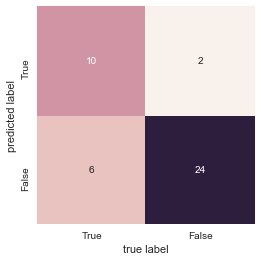

In [154]:
results = assess_results(model, X, y, data)

#### Thoughts

False positives arise when questions are either weak or procedural. These are awfully hard to catch. 

False negative appear to occur in cases where there is no question mark. Or they are talking to a state agency rep.

### Looking for specific syntactic tags

**Rules**
If it contains any question implying tags, label it a question. 

In [156]:
class my_model(object):
    def fit(self, X, y):
        pass
    
    def predict(object, X)
        rule = X.apply(sum, axis=1) > 0
        
        return rule

In [162]:
model = my_model()
X = data[count_syn_tags_cols]
y = data.question

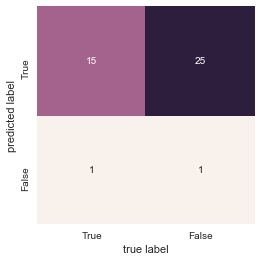

In [163]:
results = assess_results(model, X, y, data)

#### Thoughts

Clearly, I need something more sophisticated. 

## Machine Learning Approach

Obviously my sample size is super small here, but I'm just throwing a bunch of stuff against the wall to see what sticks. Later I can go through and label some more questions as well as merge my dataset with a prelabeled one to refine this. 

### Naive Bayes with TFIDF

In [171]:
model = MultinomialNB()
X = data[tfidf_score_cols + tfidf_score_answer_cols]
y = data.question

In [167]:
scores = cross_val_score(model, X, y, cv=LeaveOneOut(X.shape[0]))
scores.mean()

0.76555023923444976

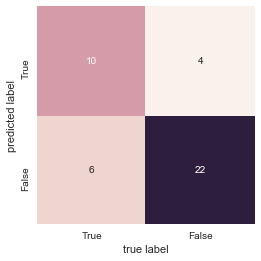

In [172]:
results = assess_results(model, X, y, data)

### Linear SVC for the sparse text matrix

Internet suggested this might be a good classifier with small number of documents

In [168]:
model = LinearSVC(dual=False)
X = data[tfidf_score_cols + tfidf_score_answer_cols]
y = data.question

In [169]:
scores = cross_val_score(model, X, y, cv=LeaveOneOut(X.shape[0]))
scores.mean()

0.69856459330143539

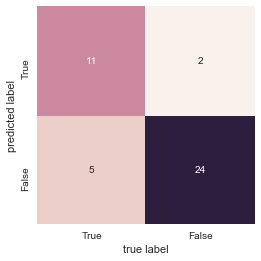

In [170]:
results = assess_results(model, X, y, data)

### Logistic Regression with TF-IDF

In [173]:
model = LogisticRegression()
X = data[tfidf_score_cols + tfidf_score_answer_cols]
y = data.question

In [174]:
scores = cross_val_score(model, X, y, cv=LeaveOneOut(X.shape[0]))
scores.mean()

0.74641148325358853

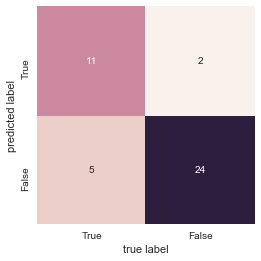

In [175]:
results = assess_results(model, X, y, data)

### Naive Bayes with Word Counts

In [176]:
model = MultinomialNB()
X = data[word_count_cols + word_count_answer_cols]
y = data.question

In [177]:
scores = cross_val_score(model, X, y, cv=LeaveOneOut(X.shape[0]))
scores.mean()

0.71770334928229662

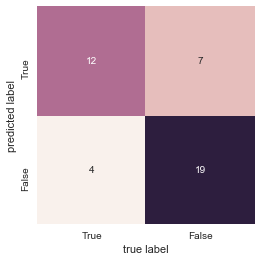

In [178]:
results = assess_results(model, X, y, data)

### Linear SVC with Word Counts

In [179]:
model = LinearSVC(dual=False)
X = data[word_count_cols + word_count_answer_cols]
y = data.question

In [180]:
scores = cross_val_score(model, X, y, cv=LeaveOneOut(X.shape[0]))
scores.mean()

0.66507177033492826

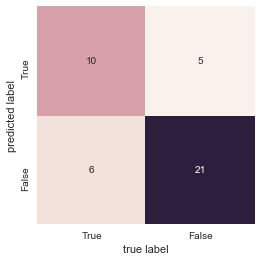

In [181]:
results = assess_results(model, X, y, data)

### Naive Bayes and Bigrams

In [182]:
model = MultinomialNB()
X = data[tfidf_bigram_cols + tfidf_bigram_answer_cols]
y = data.question

In [183]:
scores = cross_val_score(model, X, y, cv=LeaveOneOut(X.shape[0]))
scores.mean()

0.69377990430622005

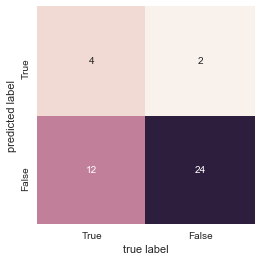

In [184]:
results = assess_results(model, X, y, data)

### Naive Bayes and Parse Trees

In [185]:
model = MultinomialNB()
X = data[tfidf_syn_tags_cols]
y = data.question

In [186]:
scores = cross_val_score(model, X, y, cv=LeaveOneOut(X.shape[0]))
scores.mean()

0.61244019138755978

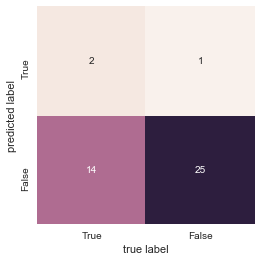

In [187]:
results = assess_results(model, X, y, data)